In [906]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load data

In [907]:
# open dataset
df = pd.read_csv('../data/dataset.csv')

Remove rows with missing collective action score

In [908]:
# remove rows with missing values in CollectiveAction
df = df.dropna(subset=['CollectiveAction'])

# Regression

Variables definition

In [909]:
# Add a constant term for the intercept in the regression model
X = sm.add_constant(df[['CommentsClean',
       'VideoCommentAlignment', 'ContentConcentration', 'CareScore', 'FairnessScore', 'LoyaltyScore', 'AuthorityScore',
       'SanctityScore']])
y = df['CollectiveAction']

Analyze variables

In [910]:
# plot the correlation matrix
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm')


/Users/arpe/miniconda3/envs/py38/lib/python3.8/site-packages/pandas/io/formats/style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Users/arpe/miniconda3/envs/py38/lib/python3.8/site-packages/pandas/io/formats/style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,const,CommentsClean,VideoCommentAlignment,ContentConcentration,CareScore,FairnessScore,LoyaltyScore,AuthorityScore,SanctityScore
const,nan,nan,nan,nan,nan,nan,nan,nan,nan
CommentsClean,nan,1.000000,0.118820,-0.048244,0.091086,0.183983,0.026091,0.158553,0.142919
VideoCommentAlignment,nan,0.118820,1.000000,-0.175523,0.151749,0.158502,-0.068318,-0.002734,0.093909
ContentConcentration,nan,-0.048244,-0.175523,1.000000,0.162183,0.246462,-0.049335,-0.126781,0.088769
CareScore,nan,0.091086,0.151749,0.162183,1.000000,0.414311,0.312381,0.200973,0.437157
FairnessScore,nan,0.183983,0.158502,0.246462,0.414311,1.000000,0.141693,0.346317,0.393385
LoyaltyScore,nan,0.026091,-0.068318,-0.049335,0.312381,0.141693,1.000000,0.260842,0.218075
AuthorityScore,nan,0.158553,-0.002734,-0.126781,0.200973,0.346317,0.260842,1.000000,0.309663
SanctityScore,nan,0.142919,0.093909,0.088769,0.437157,0.393385,0.218075,0.309663,1.000000


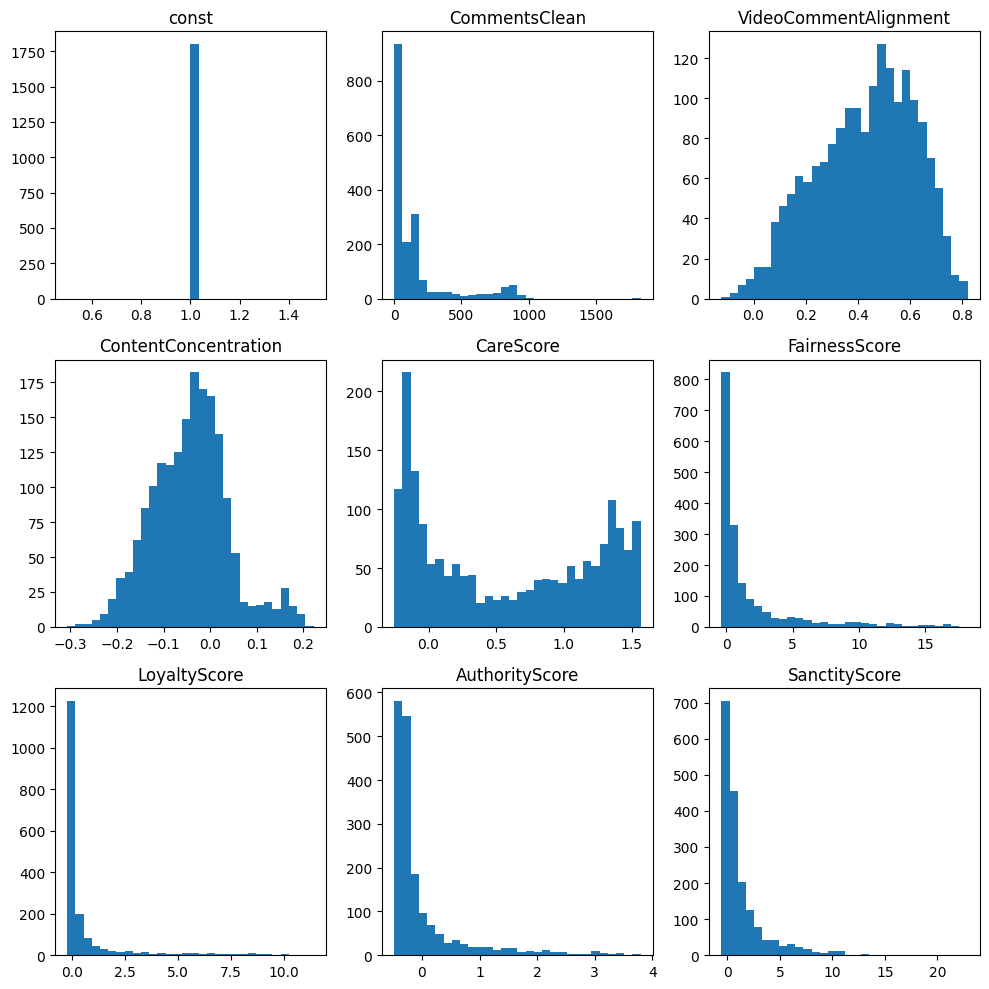

In [911]:
# plot distribution of each variable
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.hist(X.iloc[:, i], bins=30)
    ax.set_title(X.columns[i])
plt.tight_layout()
plt.show()

Transform variables

In [912]:
X['CommentsClean'] = np.log(X['CommentsClean'])

In [913]:
# moral dimensions
X[['FairnessScore', 'AuthorityScore', 'LoyaltyScore']] = np.sqrt(X[['FairnessScore', 'AuthorityScore', 'LoyaltyScore']] + 1)
X['SanctityScore'] = np.log(X['SanctityScore'] + 1)

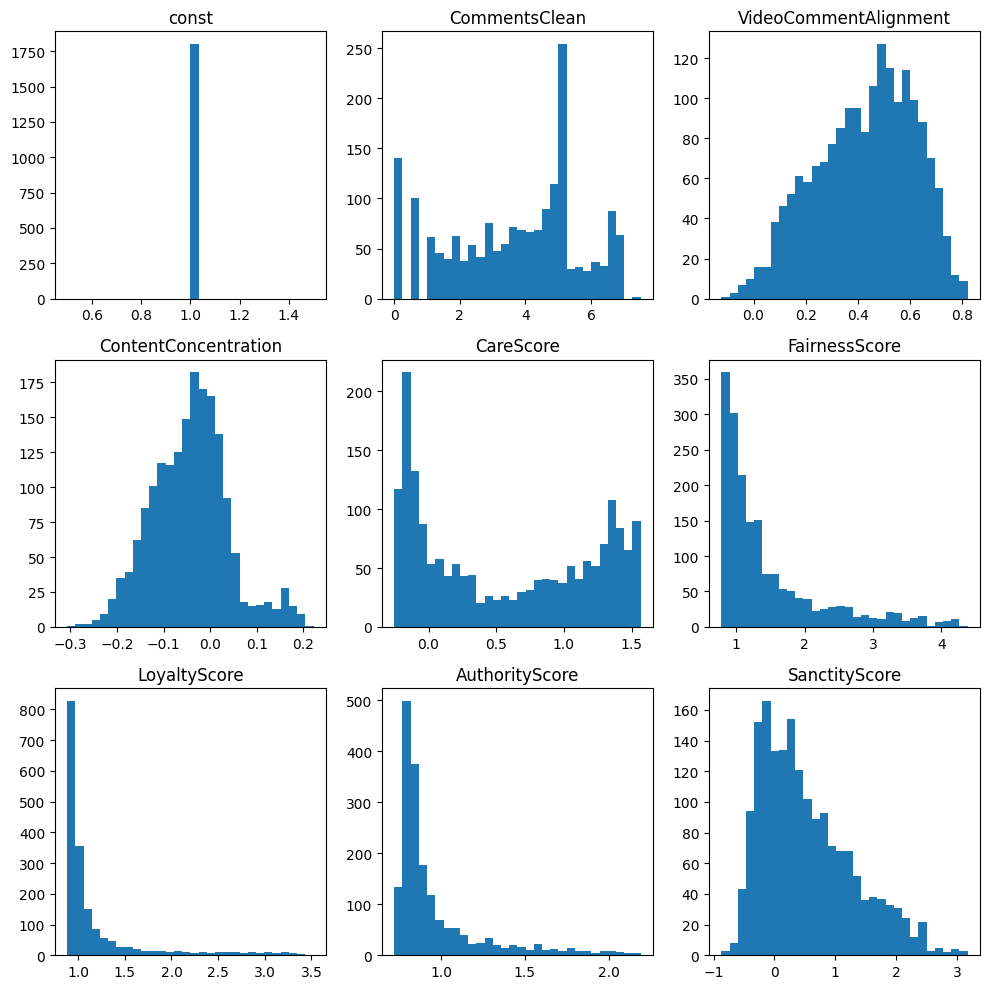

In [914]:
# plot distribution of each variable
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.hist(X.iloc[:, i], bins=30)
    ax.set_title(X.columns[i])
plt.tight_layout()
plt.show()

Z-scores of all variables

In [915]:
X['CommentsClean'] = (X['CommentsClean'] - X['CommentsClean'].mean())/X['CommentsClean'].std()
X['VideoCommentAlignment'] = (X['VideoCommentAlignment'] - X['VideoCommentAlignment'].mean())/X['VideoCommentAlignment'].std()
X['ContentConcentration'] = (X['ContentConcentration'] - X['ContentConcentration'].mean())/X['ContentConcentration'].std()
X['CareScore'] = (X['CareScore'] - X['CareScore'].mean())/X['CareScore'].std()
X['FairnessScore'] = (X['FairnessScore'] - X['FairnessScore'].mean())/X['FairnessScore'].std()
X['LoyaltyScore'] = (X['LoyaltyScore'] - X['LoyaltyScore'].mean())/X['LoyaltyScore'].std()
X['AuthorityScore'] = (X['AuthorityScore'] - X['AuthorityScore'].mean())/X['AuthorityScore'].std()
X['SanctityScore'] = (X['SanctityScore'] - X['SanctityScore'].mean())/X['SanctityScore'].std()

y = (y - y.mean())/y.std()

## Fit the model

In [916]:
model = sm.OLS(y, X).fit()

Hypothesis 1: linearity

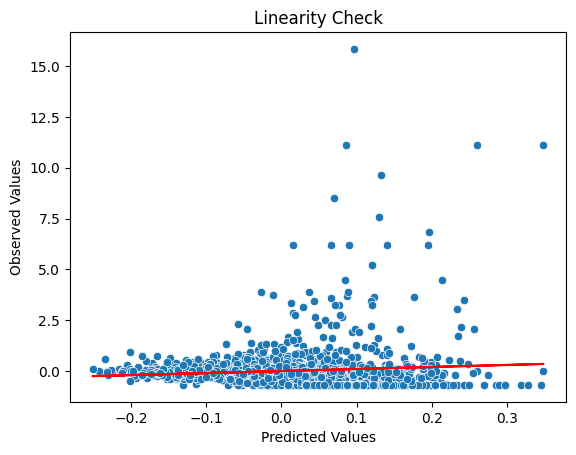

In [917]:
y_pred = model.predict(X)

# Check linearity with a scatter plot
sns.scatterplot(x=y_pred, y=y)
# add a line
plt.plot(y_pred, y_pred, color='red')
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.title('Linearity Check')
plt.show()

Hypothesis 2: Homoscedascity

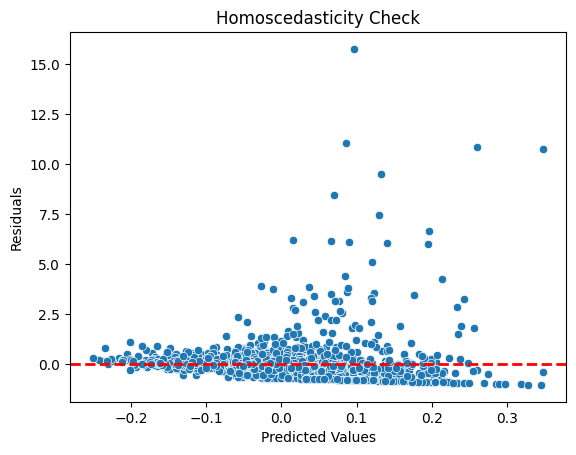

In [918]:
residuals = y - y_pred

sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Homoscedasticity Check')
plt.show()

Hypothesis 3: normality of errors

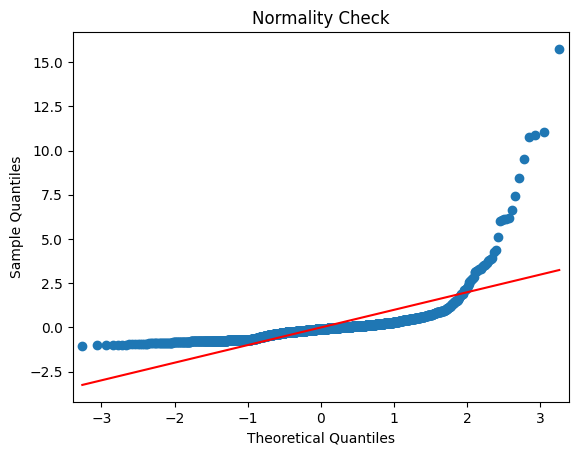

In [919]:
residuals = model.resid

# Check normality with a Q-Q plot
sm.qqplot(residuals, line='s')
plt.title('Normality Check')
plt.show()

Hypothesis 4: Multicollinearity

In [920]:
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values(by='VIF', ascending=False))

                Variable       VIF
4              CareScore  1.830801
8          SanctityScore  1.726410
5          FairnessScore  1.622963
7         AuthorityScore  1.379613
2  VideoCommentAlignment  1.318007
6           LoyaltyScore  1.273821
1          CommentsClean  1.240443
3   ContentConcentration  1.174852
0                  const  1.000000


# Regression results

In [921]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       CollectiveAction   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.889
Date:                Fri, 12 Jan 2024   Prob (F-statistic):             0.0578
Time:                        13:37:33   Log-Likelihood:                -2547.4
No. Observations:                1801   AIC:                             5113.
Df Residuals:                    1792   BIC:                             5162.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   1.16e-